In [2]:
%cd ..

/mnt/cup/labs/hasson/zaid/fmri-convs


- https://brainhack101.github.io/introML-book/01/MAIN_tutorial_intro_to_nilearn.html#visualizing-neuroimaging-volumes
- /jukebox/tamir/ltsoi/Onboarding/sebastian/sam_approach_denoising/output_denoised_wrun

In [53]:
import sys
from importlib import reload
reload(sys.modules['encoding'])
# reload(sys.modules['util.path'])
# resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e9

<module 'encoding' from '/mnt/cup/labs/hasson/zaid/fmri-convs/code/encoding.py'>

In [54]:
import encoding as enc

In [11]:
data = enc.get_bold(4, space='fsaverage6')
data.shape

fitting
fitting
fitting
fitting
fitting


(1200, 81924)

In [55]:
X, features = enc.build_regressors(4, modelname='model-gpt2-medium_layer-0.75')
X.shape

(1200, 2051)

In [56]:
(X[:, 0].astype(bool) & X[:, 1].astype(bool)).sum()

7

In [44]:
feature_names = list(features.keys())
slices = list(features.values())

In [47]:
pipeline = enc.build_model(feature_names, slices, np.linspace(0,1,10), 0, 1)
pipeline

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(n_jobs=1,
                                  transformers=[('nuissance',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,
                                                                                  4,
                                                                                  5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(0, 3, None)),
                                                ('producton',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,...
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,
                                                                                  4,
                                                                                  5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(1027, 2051, None))])),
                ('caster', Caster()),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver_params={'alphas': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                                      'progress_bar': 0}))])

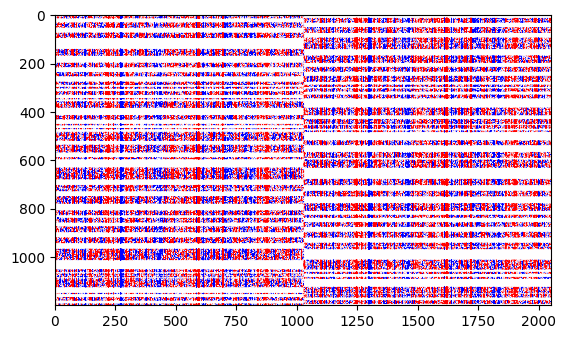

In [35]:
plt.imshow(X, vmin=-1, vmax=1, cmap='bwr')

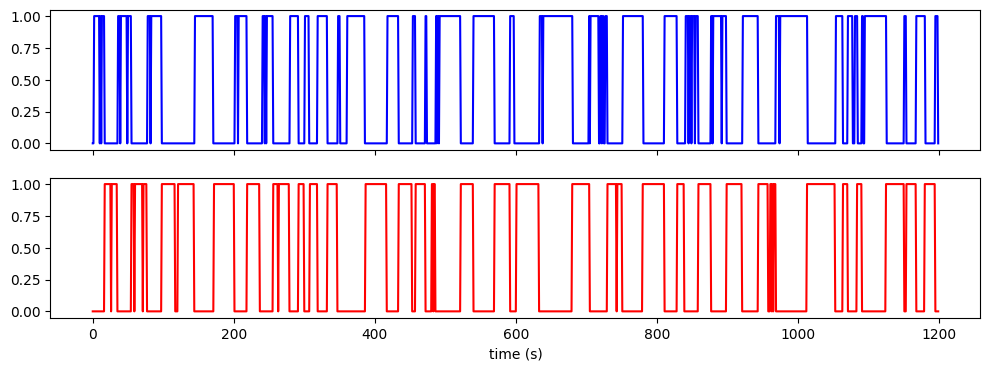

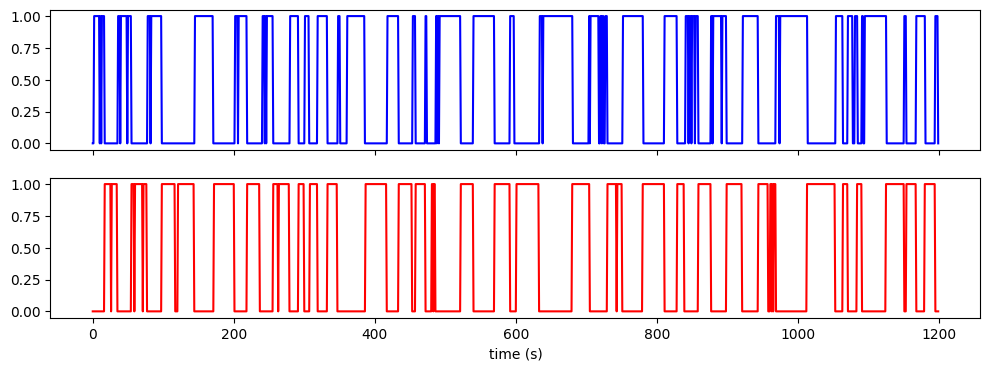

In [57]:
enc.plotboxcar(X[:, 0], X[:, 1])

In [32]:
from glob import glob

import pickle
import numpy as np
from voxelwise_tutorials.delayer import Delayer
import matplotlib.pyplot as plt
from nilearn.glm.first_level import glover_hrf
from himalaya.viz import plot_alphas_diagnostic
from nilearn.plotting import plot_glass_brain

import pandas as pd
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from util.path import Path
from constants import RUNS, NRUNS, TR

In [7]:
sub = 4
conv = str(sub + 100 if sub < 100 else sub)
modelname = "gpt2"
modelname = "glove-300"

load brain data and timing file

In [38]:
eventpath = Path(
    root="stimuli",
    conv=conv,
    datatype="timing",
    run=0,
    suffix="events",
    ext=".csv",
)

dfs = []
for run in RUNS:
    eventpath = eventpath.update(run=run)
    dft = pd.read_csv(eventpath)
    dfs.append(dft)
dft = pd.concat(dfs).reset_index(drop=True)

# keep only condition and when trials start and end
# we have to take line after `trial_intro` because there is the prompt screen
ids = sorted((dft[dft.role == 'trial_intro'].index + 1).tolist() + (dft[dft.role == 'trial_end'].index).tolist())
dft2 = dft.iloc[ids]
dft2 = dft2[dft2.condition == 'G']

dft2

,run,trial,item,condition,role,time.time,run.time,comm.time,audio_position
2,1,1.0,2.0,G,listener,1.581631e+09,21.048367,0.000014,0
9,1,1.0,2.0,G,trial_end,1.581632e+09,201.111055,180.062701,5726208
27,1,4.0,4.0,G,speaker,1.581632e+09,624.335263,0.000014,17182720
33,1,4.0,4.0,G,trial_end,1.581632e+09,804.371128,180.035880,22908928
42,2,2.0,5.0,G,listener,1.581633e+09,222.127580,0.000013,28651520
51,2,2.0,5.0,G,trial_end,1.581633e+09,402.208650,180.081084,34373632
53,2,3.0,8.0,G,listener,1.581633e+09,423.241709,0.000014,34373632
60,2,3.0,8.0,G,trial_end,1.581633e+09,603.356335,180.114643,40108032
74,3,2.0,9.0,G,speaker,1.581633e+09,222.108160,0.000013,51589120
80,3,2.0,9.0,G,trial_end,1.581634e+09,402.205690,180.097546,57319424


load brain data

In [9]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=1000, resolution_mm=2)
# plotting.plot_roi(atlas.maps)

In [40]:
import warnings

boldpath = Path(
    root="data/derivatives/fmriprep",
    sub=f"{sub:03d}",
    ses="1",
    datatype="func",
    task="Conv",
    run=1,
    space="MNI152NLin2009cAsym",  # check MNI space of ROI
    desc="preproc",
    suffix="bold",
    ext=".nii.gz",
)

confounds = ['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
'a_comp_cor_04','trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
'cosine00']

sub_maskers = []
bold_trials = []
for run in RUNS:
    boldpath = boldpath.update(run=run)
    print(run, boldpath.fpath)

    confoundpath = boldpath.copy()
    del confoundpath['space']
    confoundpath.update(desc='confounds', suffix='timeseries', ext='.tsv')
    confound_df = pd.read_csv(confoundpath, sep='\t', usecols=confounds)

    # Resample
    label_masker = NiftiLabelsMasker(labels_img=atlas.maps)
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        fmri_matrix = label_masker.fit_transform(boldpath, confounds=confound_df.to_numpy())
    # print(fmri_matrix.shape)  # 544, 400
    sub_maskers.append(label_masker)

    trial_times = (dft2[dft2.run == run]['run.time'] / TR).round().astype(int).tolist()
    # print(trial_times)
    t1onset, t1offset = trial_times[0:2]
    t2onset, t2offset = trial_times[2:4]

    bold_trials.append(fmri_matrix[t1onset:t1offset])
    bold_trials.append(fmri_matrix[t2onset:t2offset])

print([x.shape for x in bold_trials])
Y_bold = np.vstack(bold_trials)
Y_bold.shape

1 data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Conv_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(544, 1000)
[14, 134, 416, 536]
2 data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Conv_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(544, 1000)
[148, 268, 282, 402]
3 data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Conv_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(544, 1000)
[148, 268, 282, 402]
4 data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Conv_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(544, 1000)
[14, 134, 416, 536]
5 data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Conv_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(544, 1000)
[148, 268, 282, 402]
[(120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000), (120, 1000)]


(1200, 1000)

In [44]:
# Load embeddings for all runs and trials (as available)
embpath = Path(
    root="embeddings",
    conv=conv,
    datatype=modelname,
    # suffix="transcript",
    ext=".pkl",
)
files = sorted(glob(embpath.starstr(['conv', 'datatype'])))
assert len(files)
dfs = []
for fname in files:
    df = pd.read_pickle(fname)

    # # NOTE - temporary fix to put correct speaker labels
    # # probably incorrect fix tho
    # first = Path.frompath(fname)['first']
    # convid = int(conv)
    # turns = df.turn.unique()
    # starting = [convid - 100, convid] if first == 'A' else [convid, convid - 100]
    # speakers = np.tile(starting, len(turns))
    # turn2spk = {turn: spk for turn, spk in zip(turns, speakers)}
    # df['speaker'] = df.groupby('turn').turn.transform(lambda x: turn2spk[x.iloc[0]])

    dfs.append(df)
dfemb = pd.concat(dfs).reset_index(drop=True)

In [50]:
dfemb.dropna(axis=0, subset=['embedding'], inplace=True)

In [ ]:
# dfemb.groupby(['run', 'trial', 'turn'])[['onset', 'offset', 'speaker']].first()
# dfemb[dfemb.turn == 1].groupby(['run', 'trial',]).speaker.first()

In [52]:
# Build regressors per TR
stim_trs = 120

X_emb = []
X_pci = []

for (run, trial), subdf in dfemb.groupby(['run', 'trial']):
    print(run, trial, subdf.shape)

    dims = len(subdf.iloc[0].embedding)
    nwords = np.zeros(stim_trs)
    embeddings = np.zeros((stim_trs, dims))
    in_prod = np.zeros(stim_trs, dtype=bool)

    # Go through one TR at a time and find words that fall within this TR
    # average their embeddings, get num of words, etc
    for t in range(stim_trs):
        start_s = t * TR
        end_s = start_s + TR
        mask = (subdf.onset <= end_s) & (subdf.onset > start_s)
        if mask.any():
            nwords[t] = len(subdf)
            in_prod[t] = subdf[mask].speaker.iloc[0] == sub
            embeddings[t] = np.vstack(subdf[mask].embedding).mean(axis=0, keepdims=True)
    in_comp = ~ in_prod

    # Split embeddings into production and comprehension
    prod_embeddings = np.zeros_like(embeddings)
    comp_embeddings = np.zeros_like(embeddings)
    prod_embeddings[in_prod] = embeddings[in_prod]
    comp_embeddings[in_comp] = embeddings[in_comp]
    X_emb.append(np.hstack((prod_embeddings, comp_embeddings)))

    # Convolve prod/comp indicators
    hrf = glover_hrf(TR, oversampling=TR, time_length=32)  # check time_length default, maybe 20, is it TR or s
    prod_id = np.convolve(in_prod, hrf, mode='same')
    comp_id = np.convolve(in_comp, hrf, mode='same')
    X_pci.append(np.stack((prod_id, comp_id), axis=1))

X_emb = np.vstack(X_emb)
X_pci = np.vstack(X_pci)
X_emb.shape, X_pci.shape

1 1 (438, 12)
1 4 (538, 12)
2 6 (495, 12)
2 7 (492, 12)
3 10 (517, 12)
3 11 (528, 12)
4 13 (493, 12)
4 16 (517, 12)
5 18 (532, 12)
5 19 (526, 12)


((1200, 600), (1200, 2))

# Modeling

In [53]:
from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import Kernelizer, ColumnKernelizer
from sklearn.pipeline import make_pipeline
from himalaya.scoring import correlation_score, correlation_score_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import make_pipeline

In [54]:
alphas = np.logspace(-1, 8, 10)
alphas

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08])

In [55]:
preprocess_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Kernelizer(kernel="linear"),
)

emb_preprocess_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    Kernelizer(kernel="linear"),
)

In [56]:
# feature_names = ('pc_indicator', 'embedding')
# pipelines = (preprocess_pipeline, emb_preprocess_pipeline)
# slices = [slice(0, 2), slice(2, None)]

feature_names = ('pc_indicator', 'prod', 'comp')
pipelines = (preprocess_pipeline, emb_preprocess_pipeline, emb_preprocess_pipeline)
slices = [slice(0, 2), slice(2, dims+2), slice(dims+2, None)]

slices

[slice(0, 2, None), slice(2, 302, None), slice(302, None, None)]

In [57]:
# Make kernelizer
kernelizers_tuples = [(name, pipe_, slice_)
                      for name, pipe_, slice_ in zip(feature_names, pipelines, slices)]
column_kernelizer = ColumnKernelizer(kernelizers_tuples, n_jobs=len(feature_names))
column_kernelizer

ColumnKernelizer(n_jobs=3,
                 transformers=[('pc_indicator',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('kernelizer', Kernelizer())]),
                                slice(0, 2, None)),
                               ('prod',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('delayer',
                                                 Delayer(delays=[1, 2, 3, 4])),
                                                ('kernelizer', Kernelizer())]),
                                slice(2, 302, None)),
                               ('comp',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('delayer',
                                                 Delayer(delays=[1, 2, 3, 4])),
                                                ('kernelizer', Kernelizer())]),
                                slice(302, None, None))])

In [58]:
mkr_model = MultipleKernelRidgeCV(kernels="precomputed",
                                  solver_params=dict(alphas=alphas, progress_bar=False))  # NOTE try with this
pipeline = make_pipeline(
    column_kernelizer,
    mkr_model,
)
pipeline

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(n_jobs=3,
                                  transformers=[('pc_indicator',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(0, 2, None)),
                                                ('prod',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[1,
                                                                                  2,
                                                                                  3,
                                                                                  4])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 sli...
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[1,
                                                                                  2,
                                                                                  3,
                                                                                  4])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(302, None, None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver_params={'alphas': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08]),
                                                      'progress_bar': False}))])

In [ ]:
# https://gallantlab.org/voxelwise_tutorials/_auto_examples/shortclips/06_plot_banded_ridge_model.html

cv_scores = []
cv_models = []
cv_alphas = []

run_ids = np.repeat(np.arange(NRUNS), stim_trs*2)
kfold = PredefinedSplit(run_ids)

for k, (train_index, test_index) in enumerate(kfold.split()):

    # print(k, resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e9)

    X_emb_train = X_emb[train_index]
    X_pci_train = X_pci[train_index]
    X_train = np.hstack((X_pci_train, X_emb_train))
    X_test = np.hstack((X_pci[test_index], X_emb[test_index]))

    Y_train = Y_bold[train_index]
    Y_test = Y_bold[test_index]
    Y_train -= Y_train.mean(0)
    Y_test -= Y_test.mean(0)

    pipeline = make_pipeline(
        column_kernelizer,
        mkr_model,
    )
    pipeline['multiplekernelridgecv'].cv = PredefinedSplit(run_ids[train_index])
    pipeline.fit(X_train, Y_train)

    Y_test_pred_split = pipeline.predict(X_test, split=True)
    split_scores_mask = correlation_score_split(Y_test, Y_test_pred_split)

    enc_model = pipeline['multiplekernelridgecv']
    cv_models.append(enc_model)
    cv_scores.append(split_scores_mask)
    cv_alphas.append(enc_model.best_alphas_)

    # break  # NOTE

In [ ]:
result = {
    'masker': sub_maskers[0],
    'cv_models': cv_models,
    'cv_scores': cv_scores,
    'cv_alphas': cv_alphas
}

In [ ]:
pklpath = Path(
    root="encoding",
    sub=f"{sub:03d}",
    datatype="gpt2",  # NOTE
    ext=".pkl",
)
pklpath.mkdirs()
with open(pklpath.fpath, 'wb') as f:
    pickle.dump(result, f)

In [ ]:
preds1 = pipeline.predict(X_test)
scores1 = correlation_score(Y_test, preds1)

In [ ]:
plt.figure()
for i, feature in enumerate(feature_names):
    plt.hist(split_scores_mask[i], alpha=0.5, label=feature, bins=20)
plt.legend()
plt.show()

In [ ]:
best_alphas = pipeline['multiplekernelridgecv'].best_alphas_
plot_alphas_diagnostic(best_alphas, alphas)
plt.title("Best alphas selected by cross-validation")
plt.show()

In [ ]:
all_scores = np.mean(scores, axis=0)
all_scores.shape

In [ ]:
out = sub_maskers[0].inverse_transform(all_scores.sum(0))
plot_glass_brain(out, title='all', colorbar=True, cmap='hot_white_bone_r', plot_abs=True)

In [ ]:
for i, feature in enumerate(feature_names):
    out = sub_maskers[0].inverse_transform(all_scores[i])
    plot_glass_brain(out, title=feature, colorbar=True, cmap='bwr', plot_abs=False, threshold=0.1)